### 감성분석
- LSTM 모델링 및 테스트
- 인프라 리뷰 감성분석

- 사용 라이브러리 로드

In [40]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
from collections import Counter
from konlpy.tag import Okt
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.layers import Embedding, Dense, LSTM, Dropout, GRU
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tqdm import tqdm
import mysql.connector

1. 데이터 전처리

In [2]:
total_data = pd.read_table('https://raw.githubusercontent.com/bab2min/corpus/master/sentiment/naver_shopping.txt', names=['ratings', 'reviews'])
print('전체 리뷰 개수 :',len(total_data)) # 전체 리뷰 개수 출력

전체 리뷰 개수 : 200000


In [3]:
total_data['label'] = np.select([total_data.ratings > 3], [1], default=0)
total_data[:5]

,ratings,reviews,label
0,5,배공빠르고 굿,1
1,2,택배가 엉망이네용 저희집 밑에층에 말도없이 놔두고가고,0
2,5,아주좋아요 바지 정말 좋아서2개 더 구매했어요 이가격에 대박입니다. 바느질이 조금 ...,1
3,2,선물용으로 빨리 받아서 전달했어야 하는 상품이었는데 머그컵만 와서 당황했습니다. 전...,0
4,5,민트색상 예뻐요. 옆 손잡이는 거는 용도로도 사용되네요 ㅎㅎ,1


In [4]:
total_data.drop_duplicates(subset=['reviews'], inplace=True) # reviews 열에서 중복인 내용이 있다면 중복 제거
print('총 샘플의 수 :',len(total_data))

총 샘플의 수 : 199908


In [5]:
print(total_data.isnull().values.any())

False


In [6]:
train_data, test_data = train_test_split(total_data, test_size = 0.25, random_state = 42)
print('훈련용 리뷰의 개수 :', len(train_data))
print('테스트용 리뷰의 개수 :', len(test_data))

훈련용 리뷰의 개수 : 149931
테스트용 리뷰의 개수 : 49977


<Axes: xlabel='label'>

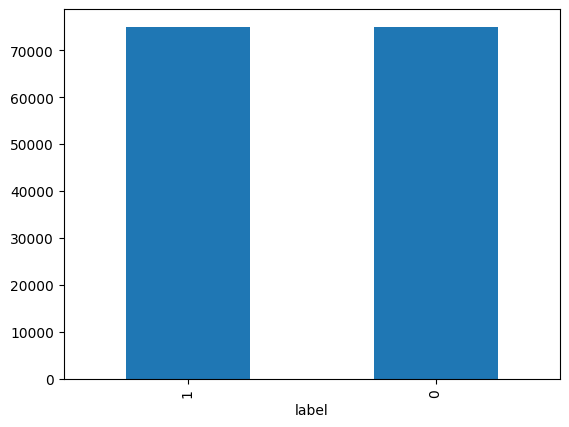

In [7]:
train_data['label'].value_counts().plot(kind = 'bar')

In [8]:
# 한글과 공백을 제외하고 모두 제거
train_data['reviews'] = train_data['reviews'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","", regex=True)
train_data['reviews'].replace('', np.nan, inplace=True)
print(train_data.isnull().sum())

ratings    0
reviews    0
label      0
dtype: int64


/var/folders/1g/mh4r7xrj5gg2lcbjp9rv33fr0000gn/T/ipykernel_15938/482251640.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  train_data['reviews'].replace('', np.nan, inplace=True)


In [9]:
test_data.drop_duplicates(subset = ['reviews'], inplace=True) # 중복 제거
test_data['reviews'] = test_data['reviews'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","", regex=True) # 정규 표현식 수행
test_data['reviews'].replace('', np.nan, inplace=True) # 공백은 Null 값으로 변경
test_data = test_data.dropna(how='any') # Null 값 제거
print('전처리 후 테스트용 샘플의 개수 :',len(test_data))

전처리 후 테스트용 샘플의 개수 : 49977


/var/folders/1g/mh4r7xrj5gg2lcbjp9rv33fr0000gn/T/ipykernel_15938/3349398511.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  test_data['reviews'].replace('', np.nan, inplace=True) # 공백은 Null 값으로 변경


In [12]:
okt = Okt()


In [13]:
stopwords = ['도', '는', '다', '의', '가', '이', '은', '한', '에', '하', '고', '을', '를', '인', '듯', '과', '와', '네', '들', '듯', '지', '임', '게']

In [15]:
train_data['tokenized'] = train_data['reviews'].apply(okt.morphs)
train_data['tokenized'] = train_data['tokenized'].apply(lambda x: [item for item in x if item not in stopwords])

In [16]:
test_data['tokenized'] = test_data['reviews'].apply(okt.morphs)
test_data['tokenized'] = test_data['tokenized'].apply(lambda x: [item for item in x if item not in stopwords])


In [17]:
negative_words = np.hstack(train_data[train_data.label == 0]['tokenized'].values)
positive_words = np.hstack(train_data[train_data.label == 1]['tokenized'].values)

In [18]:
negative_word_count = Counter(negative_words)
print(negative_word_count.most_common(20))

[(np.str_('너무'), 13039), (np.str_('요'), 11784), (np.str_('안'), 11676), (np.str_('배송'), 9171), (np.str_('그냥'), 8518), (np.str_('잘'), 7817), (np.str_('로'), 5777), (np.str_('했는데'), 5692), (np.str_('별로'), 5549), (np.str_('못'), 5174), (np.str_('제품'), 5071), (np.str_('으로'), 4999), (np.str_('생각'), 4927), (np.str_('좀'), 4878), (np.str_('사용'), 4846), (np.str_('하고'), 4769), (np.str_('ㅠㅠ'), 4760), (np.str_('구매'), 4634), (np.str_('보다'), 4617), (np.str_('맛'), 4017)]


In [19]:
positive_word_count = Counter(positive_words)
print(positive_word_count.most_common(20))

[(np.str_('잘'), 15302), (np.str_('좋아요'), 14527), (np.str_('배송'), 12251), (np.str_('너무'), 9100), (np.str_('재구매'), 8573), (np.str_('구매'), 7186), (np.str_('요'), 6639), (np.str_('사용'), 5415), (np.str_('가격'), 5015), (np.str_('으로'), 4477), (np.str_('같아요'), 4434), (np.str_('로'), 4318), (np.str_('좋네요'), 4221), (np.str_('빠르고'), 4025), (np.str_('보다'), 3955), (np.str_('제품'), 3950), (np.str_('주문'), 3815), (np.str_('입니다'), 3769), (np.str_('생각'), 3491), (np.str_('했어요'), 3367)]


긍정 리뷰의 평균 길이 : 10.768613440337008
부정 리뷰의 평균 길이 : 14.101804639739449


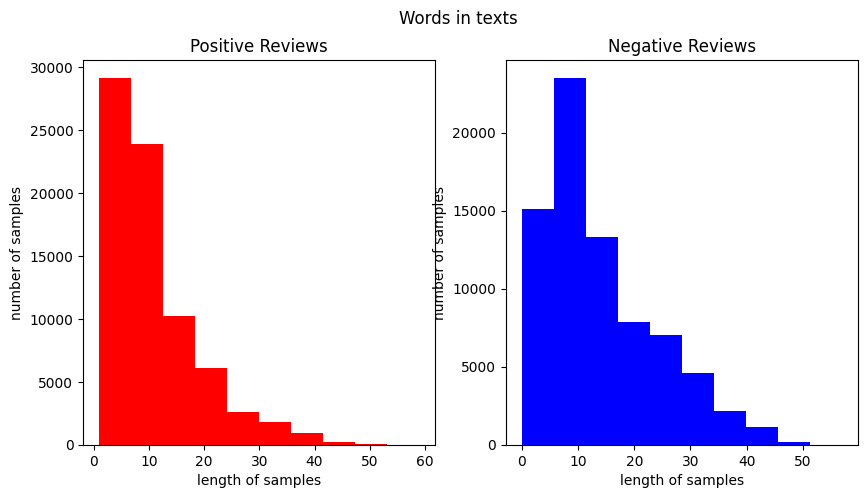

In [20]:
fig,(ax1,ax2) = plt.subplots(1,2,figsize=(10,5))
text_len = train_data[train_data['label']==1]['tokenized'].map(lambda x: len(x))
ax1.hist(text_len, color='red')
ax1.set_title('Positive Reviews')
ax1.set_xlabel('length of samples')
ax1.set_ylabel('number of samples')
print('긍정 리뷰의 평균 길이 :', np.mean(text_len))

text_len = train_data[train_data['label']==0]['tokenized'].map(lambda x: len(x))
ax2.hist(text_len, color='blue')
ax2.set_title('Negative Reviews')
fig.suptitle('Words in texts')
ax2.set_xlabel('length of samples')
ax2.set_ylabel('number of samples')
print('부정 리뷰의 평균 길이 :', np.mean(text_len))
plt.show()

In [21]:
X_train = train_data['tokenized'].values
y_train = train_data['label'].values
X_test= test_data['tokenized'].values
y_test = test_data['label'].values

In [22]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)

In [23]:
threshold = 2
total_cnt = len(tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :',total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 94361
등장 빈도가 1번 이하인 희귀 단어의 수: 52344
단어 집합에서 희귀 단어의 비율: 55.47207002893144
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 2.807755335212537


- 모델 성능 테스트

In [24]:
# 전체 단어 개수 중 빈도수 2이하인 단어 개수는 제거.
# 0번 패딩 토큰과 1번 OOV 토큰을 고려하여 +2
vocab_size = total_cnt - rare_cnt + 2
print('단어 집합의 크기 :',vocab_size)

단어 집합의 크기 : 42019


In [25]:
tokenizer = Tokenizer(vocab_size, oov_token = 'OOV') 
tokenizer.fit_on_texts(X_train)
X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)


리뷰의 최대 길이 : 59
리뷰의 평균 길이 : 12.43415304373345


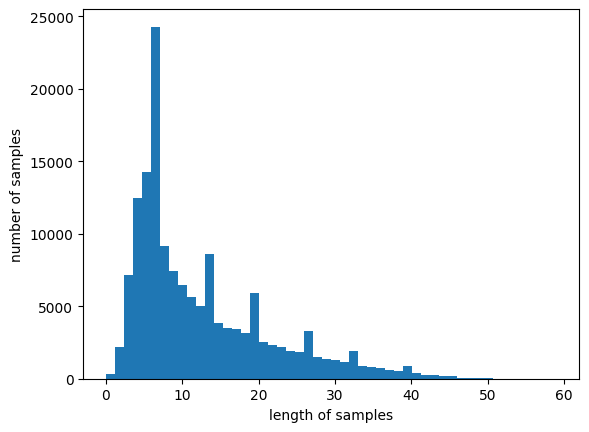

In [26]:
print('리뷰의 최대 길이 :',max(len(review) for review in X_train))
print('리뷰의 평균 길이 :',sum(map(len, X_train))/len(X_train))
plt.hist([len(review) for review in X_train], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [27]:
def below_threshold_len(max_len, nested_list):
  count = 0
  for sentence in nested_list:
    if(len(sentence) <= max_len):
        count = count + 1
  print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s'%(max_len, (count / len(nested_list))*100))

In [28]:
max_len = 80
below_threshold_len(max_len, X_train)

전체 샘플 중 길이가 80 이하인 샘플의 비율: 100.0


In [29]:
X_train = pad_sequences(X_train, maxlen=max_len)
X_test = pad_sequences(X_test, maxlen=max_len)

2 LSTM 모델링 및 테스트
- 모델 학습

In [32]:
embedding_dim = 100
hidden_units = 128

model = Sequential()
model.add(Embedding(vocab_size, embedding_dim))
model.add(GRU(hidden_units))
model.add(Dense(1, activation='sigmoid'))

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=4)
mc = ModelCheckpoint('ML_Model/sentiment_LSTM.keras', monitor='val_acc', mode='max', verbose=1, save_best_only=True)

model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
history = model.fit(X_train, y_train, epochs=15, callbacks=[es, mc], batch_size=64, validation_split=0.2)

Epoch 1/15
1874/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - acc: 0.8386 - loss: 0.3717
Epoch 1: val_acc improved from -inf to 0.90516, saving model to best_model.keras
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 97s 51ms/step - acc: 0.8386 - loss: 0.3716 - val_acc: 0.9052 - val_loss: 0.2509
Epoch 2/15
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - acc: 0.9160 - loss: 0.2321
Epoch 2: val_acc improved from 0.90516 to 0.91240, saving model to best_model.keras
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 100s 53ms/step - acc: 0.9160 - loss: 0.2321 - val_acc: 0.9124 - val_loss: 0.2408
Epoch 3/15
1874/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - acc: 0.9281 - loss: 0.2068
Epoch 3: val_acc did not improve from 0.91240
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 98s 52ms/step - acc: 0.9281 - loss: 0.2068 - val_acc: 0.9107 - val_loss: 0.2395
Epoch 4/15
1874/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - acc: 0.9377 - loss: 0.1847
Epoch 4: val_acc improved from 0.91240 to 0.91440, saving model to best_model.keras
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 106s

In [55]:
loaded_model = load_model('ML_Model/sentiment_LSTM.keras')
print("\n 테스트 정확도: %.4f" % (loaded_model.evaluate(X_test, y_test)[1]))

1562/1562 ━━━━━━━━━━━━━━━━━━━━ 13s 8ms/step - acc: 0.9159 - loss: 0.2343

 테스트 정확도: 0.9138


-   인프라 시설 리뷰 감석 분석

In [48]:
def sentiment_predict(new_sentence):
  new_sentence = re.sub(r'[^ㄱ-ㅎㅏ-ㅣ가-힣 ]','', new_sentence)
  new_sentence = okt.morphs(new_sentence)
  new_sentence = [word for word in new_sentence if not word in stopwords]
  encoded = tokenizer.texts_to_sequences([new_sentence])
  pad_new = pad_sequences(encoded, maxlen = max_len)

  score = float(loaded_model.predict(pad_new)[0][0])
  if(score > 0.5):
    return "Y"
  else:
    return "N"

In [41]:
conn = mysql.connector.connect(
    host = " database-2.c3iym8yog7ht.ap-northeast-2.rds.amazonaws.com",
    port = 3306,
    user = "pethub",
    password = "addinedu5",
    database = "pethub"
)

In [42]:
cursor = conn.cursor()
cursor.execute("SELECT * FROM review")
result = cursor.fetchall()

df = pd.DataFrame(result)
df.head()

,0,1,2,3
0,10002,1,자주 놀러가는 곳! 전반적으로 넓은 편이어서 좋아요. 봄에는 벚꽃도 예쁜 곳이예요,None
1,10003,1,그늘이 있어서 쉴수도 있고 대형견 소형견들 분리가 되어 있어 안전합니다\n강아지들이...,None
2,10004,1,크기는 보라매공원 사이즈에 비해 생각보다 아담한 듯. 깨끗하고 좋음.,None
3,10005,1,강아지가 근처만 가도 놀이터로 돌진합니다 ㅋㅋㅋㅋㅋ,None
4,10006,1,다른 강아지들하고 교류하며 사회성 기르기 좋아요. 여기 들어오는 강아지들은 비교적 ...,None


In [43]:
df.rename(columns={0: "id", 1: "infra_id", 2: "comment", 3: "setiment"}, inplace=True)
df.head()

,id,infra_id,comment,setiment
0,10002,1,자주 놀러가는 곳! 전반적으로 넓은 편이어서 좋아요. 봄에는 벚꽃도 예쁜 곳이예요,None
1,10003,1,그늘이 있어서 쉴수도 있고 대형견 소형견들 분리가 되어 있어 안전합니다\n강아지들이...,None
2,10004,1,크기는 보라매공원 사이즈에 비해 생각보다 아담한 듯. 깨끗하고 좋음.,None
3,10005,1,강아지가 근처만 가도 놀이터로 돌진합니다 ㅋㅋㅋㅋㅋ,None
4,10006,1,다른 강아지들하고 교류하며 사회성 기르기 좋아요. 여기 들어오는 강아지들은 비교적 ...,None


In [49]:
for i, row in df.iterrows():
    df.loc[i, "setiment"] = sentiment_predict(row["comment"])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━

In [53]:
sql = "UPDATE review SET setiment = %s WHERE id = %s"
for i, row in tqdm(df.iterrows()):
    cursor.execute(sql, (row["setiment"], row["id"]))
    print((row["setiment"], row["id"]))
    conn.commit()

11it [00:00, 52.15it/s]

('Y', 10002)
('Y', 10003)
('Y', 10004)
('Y', 10005)
('Y', 10006)
('N', 10007)
('N', 10008)
('Y', 10009)
('Y', 10010)
('Y', 10011)
('Y', 10012)
('N', 10013)


23it [00:00, 54.37it/s]

('Y', 10014)
('Y', 10015)
('Y', 10016)
('Y', 10017)
('N', 10018)
('Y', 10019)
('Y', 10020)
('N', 10021)
('Y', 10022)
('Y', 10023)
('Y', 10024)
('Y', 10025)


35it [00:00, 53.94it/s]

('Y', 10026)
('Y', 10027)
('Y', 10028)
('Y', 10029)
('Y', 10030)
('Y', 10031)
('N', 10032)
('N', 10033)
('Y', 10034)
('N', 10035)
('Y', 10036)
('Y', 10037)


47it [00:00, 53.72it/s]

('Y', 10038)
('Y', 10039)
('Y', 10040)
('Y', 10041)
('Y', 10042)
('Y', 10043)
('Y', 10044)
('Y', 10045)
('Y', 10046)
('N', 10047)
('Y', 10048)
('Y', 10049)


59it [00:01, 54.41it/s]

('N', 10050)
('Y', 10051)
('Y', 10052)
('Y', 10053)
('N', 10054)
('Y', 10055)
('N', 10056)
('Y', 10057)
('N', 10058)
('Y', 10059)
('N', 10060)
('N', 10061)


71it [00:01, 53.59it/s]

('Y', 10062)
('N', 10063)
('Y', 10064)
('N', 10065)
('Y', 10066)
('Y', 10067)
('Y', 10068)
('Y', 10069)
('Y', 10070)
('Y', 10071)
('Y', 10072)
('N', 10073)


83it [00:01, 51.85it/s]

('Y', 10074)
('N', 10075)
('Y', 10076)
('Y', 10077)
('Y', 10078)
('Y', 10083)
('N', 10084)
('Y', 10085)
('Y', 10086)
('Y', 10087)
('Y', 10088)


89it [00:01, 51.63it/s]

('N', 10089)
('Y', 10090)
('N', 10091)
('Y', 10092)
('Y', 10094)
('N', 10095)
('Y', 10096)
('Y', 10097)
('N', 10098)
('N', 10099)
('Y', 10100)


101it [00:01, 51.74it/s]

('N', 10101)
('Y', 10102)
('Y', 10103)
('N', 10104)
('Y', 10105)
('Y', 10106)
('Y', 10107)
('Y', 10108)
('Y', 10109)
('Y', 10110)
('N', 10112)
('Y', 10113)


113it [00:02, 52.67it/s]

('Y', 10114)
('Y', 10115)
('N', 10116)
('N', 10117)
('N', 10118)
('Y', 10119)
('N', 10120)
('Y', 10121)
('Y', 10122)
('N', 10123)


125it [00:02, 49.12it/s]

('Y', 10124)
('Y', 10125)
('Y', 10126)
('N', 10127)
('N', 10128)
('Y', 10129)
('N', 10130)
('N', 10132)
('Y', 10133)
('Y', 10134)
('Y', 10135)


137it [00:02, 51.59it/s]

('Y', 10136)
('N', 10137)
('Y', 10138)
('Y', 10139)
('Y', 10140)
('Y', 10141)
('N', 10142)
('Y', 10143)
('Y', 10144)
('Y', 10145)
('Y', 10146)
('Y', 10147)


149it [00:02, 51.87it/s]

('N', 10148)
('Y', 10149)
('Y', 10150)
('Y', 10151)
('Y', 10152)
('N', 10155)
('N', 10156)
('N', 10157)
('N', 10158)
('Y', 10159)
('Y', 10160)
('Y', 10161)


161it [00:03, 53.63it/s]

('Y', 10162)
('Y', 10163)
('N', 10164)
('Y', 10165)
('N', 10166)
('N', 10167)
('Y', 10168)
('Y', 10169)
('N', 10170)
('N', 10171)
('N', 10172)
('Y', 10173)


173it [00:03, 53.00it/s]

('N', 10174)
('Y', 10175)
('Y', 10176)
('N', 10177)
('Y', 10178)
('N', 10179)
('Y', 10180)
('Y', 10181)
('N', 10182)
('N', 10183)
('Y', 10184)
('Y', 10186)


185it [00:03, 53.08it/s]

('Y', 10187)
('Y', 10188)
('N', 10189)
('Y', 10190)
('Y', 10191)
('N', 10192)
('N', 10193)
('N', 10194)
('N', 10195)
('Y', 10196)
('N', 10197)
('Y', 10198)


197it [00:03, 52.31it/s]

('N', 10199)
('Y', 10200)
('Y', 10201)
('Y', 10202)
('N', 10203)
('Y', 10204)
('Y', 10210)
('Y', 10211)
('Y', 10212)
('Y', 10213)
('Y', 10214)
('N', 10215)


209it [00:03, 54.06it/s]

('N', 10216)
('Y', 10217)
('Y', 10218)
('Y', 10219)
('Y', 10220)
('Y', 10221)
('Y', 10222)
('Y', 10223)
('Y', 10224)
('Y', 10225)
('N', 10226)
('Y', 10227)


221it [00:04, 54.00it/s]

('Y', 10228)
('Y', 10229)
('N', 10230)
('N', 10231)
('Y', 10234)
('Y', 10235)
('Y', 10236)
('Y', 10237)
('Y', 10238)
('Y', 10239)
('Y', 10240)
('Y', 10241)


233it [00:04, 54.44it/s]

('Y', 10242)
('Y', 10243)
('Y', 10244)
('Y', 10245)
('Y', 10246)
('N', 10247)
('Y', 10248)
('Y', 10249)
('Y', 10250)
('Y', 10251)
('Y', 10252)
('N', 10253)


245it [00:04, 53.64it/s]

('N', 10254)
('Y', 10255)
('Y', 10256)
('Y', 10257)
('Y', 10258)
('Y', 10259)
('N', 10260)
('N', 10261)
('N', 10262)
('N', 10263)
('N', 10266)


257it [00:04, 54.02it/s]

('Y', 10268)
('Y', 10269)
('Y', 10273)
('Y', 10274)
('N', 10275)
('Y', 10276)
('Y', 10277)
('Y', 10278)
('Y', 10279)
('N', 10280)
('Y', 10281)
('N', 10282)
('Y', 10283)


269it [00:05, 53.58it/s]

('Y', 10284)
('N', 10285)
('Y', 10286)
('Y', 10287)
('Y', 10288)
('Y', 10289)
('Y', 10290)
('Y', 10291)
('Y', 10292)
('Y', 10293)
('Y', 10294)
('N', 10295)


282it [00:05, 54.12it/s]

('N', 10296)
('Y', 10297)
('Y', 10298)
('Y', 10299)
('Y', 10300)
('Y', 10301)
('Y', 10302)
('Y', 10303)
('Y', 10304)
('Y', 10305)
('Y', 10306)
('Y', 10307)


294it [00:05, 53.92it/s]

('N', 10308)
('Y', 10311)
('Y', 10312)
('Y', 10316)
('Y', 10317)
('N', 10318)
('Y', 10319)
('Y', 10320)
('Y', 10321)
('Y', 10322)
('Y', 10323)
('N', 10324)


306it [00:05, 54.57it/s]

('N', 10325)
('Y', 10328)
('Y', 10329)
('Y', 10330)
('Y', 10331)
('Y', 10332)
('Y', 10334)
('Y', 10335)
('Y', 10336)
('Y', 10337)
('Y', 10338)
('N', 10339)


318it [00:05, 55.48it/s]

('Y', 10340)
('Y', 10341)
('N', 10342)
('N', 10343)
('Y', 10344)
('Y', 10345)
('Y', 10346)
('Y', 10347)
('Y', 10349)
('Y', 10351)
('Y', 10352)
('Y', 10353)


330it [00:06, 54.23it/s]

('Y', 10354)
('Y', 10355)
('N', 10356)
('N', 10357)
('N', 10358)
('Y', 10359)
('Y', 10360)
('N', 10361)
('N', 10362)
('Y', 10363)
('Y', 10364)
('Y', 10365)


343it [00:06, 56.91it/s]

('Y', 10366)
('Y', 10367)
('N', 10368)
('N', 10369)
('Y', 10370)
('N', 10371)
('Y', 10372)
('Y', 10373)
('Y', 10374)
('Y', 10375)
('Y', 10376)
('N', 10377)
('N', 10378)


355it [00:06, 55.14it/s]

('Y', 10379)
('N', 10380)
('Y', 10381)
('N', 10382)
('Y', 10383)
('N', 10384)
('N', 10385)
('Y', 10386)
('Y', 10387)
('Y', 10388)
('Y', 10389)


368it [00:06, 57.79it/s]

('Y', 10390)
('Y', 10391)
('Y', 10392)
('Y', 10393)
('Y', 10394)
('Y', 10395)
('N', 10396)
('Y', 10397)
('Y', 10398)
('Y', 10399)
('N', 10400)
('Y', 10401)
('Y', 10402)


380it [00:07, 58.08it/s]

('Y', 10403)
('Y', 10404)
('Y', 10405)
('Y', 10406)
('Y', 10407)
('Y', 10408)
('Y', 10409)
('Y', 10410)
('Y', 10411)
('Y', 10412)
('Y', 10413)
('N', 10414)
('Y', 10415)


392it [00:07, 56.74it/s]

('Y', 10416)
('Y', 10417)
('Y', 10418)
('Y', 10419)
('Y', 10420)
('Y', 10421)
('Y', 10422)
('Y', 10423)
('Y', 10424)
('Y', 10425)
('Y', 10426)
('Y', 10427)


398it [00:07, 56.39it/s]

('Y', 10428)
('Y', 10429)
('Y', 10431)
('Y', 10432)
('Y', 10433)
('N', 10434)
('Y', 10435)
('Y', 10436)
('Y', 10437)
('Y', 10440)
('Y', 10441)


410it [00:07, 54.76it/s]

('Y', 10442)
('Y', 10443)
('Y', 10444)
('Y', 10445)
('Y', 10446)
('Y', 10447)
('Y', 10448)
('Y', 10449)
('Y', 10450)
('Y', 10453)
('Y', 10454)
('Y', 10455)


428it [00:07, 56.20it/s]

('Y', 10456)
('Y', 10457)
('Y', 10458)
('N', 10459)
('N', 10460)
('Y', 10461)
('N', 10462)
('Y', 10463)
('Y', 10464)
('N', 10465)
('N', 10466)
('N', 10467)
('Y', 10469)


440it [00:08, 55.55it/s]

('Y', 10470)
('Y', 10471)
('Y', 10472)
('Y', 10473)
('Y', 10474)
('Y', 10475)
('N', 10476)
('Y', 10479)
('Y', 10480)
('Y', 10481)
('Y', 10484)
('Y', 10485)


452it [00:08, 53.34it/s]

('Y', 10486)
('Y', 10487)
('Y', 10488)
('Y', 10489)
('Y', 10490)
('N', 10491)
('Y', 10492)
('N', 10493)
('Y', 10494)
('N', 10495)
('Y', 10496)
('Y', 10497)


458it [00:08, 50.55it/s]

('N', 10498)
('Y', 10499)
('Y', 10500)
('Y', 10501)
('Y', 10502)
('N', 10503)
('Y', 10504)
('Y', 10505)
('Y', 10506)
('Y', 10507)


470it [00:08, 52.04it/s]

('Y', 10508)
('Y', 10509)
('Y', 10510)
('Y', 10511)
('Y', 10512)
('Y', 10513)
('Y', 10514)
('Y', 10515)
('N', 10516)
('Y', 10517)
('Y', 10518)
('Y', 10519)


482it [00:08, 53.72it/s]

('N', 10520)
('Y', 10521)
('Y', 10522)
('Y', 10523)
('N', 10524)
('Y', 10527)
('Y', 10528)
('Y', 10529)
('Y', 10530)
('Y', 10531)
('N', 10532)
('Y', 10533)
('Y', 10534)


494it [00:09, 53.75it/s]

('N', 10535)
('Y', 10536)
('Y', 10537)
('Y', 10538)
('Y', 10539)
('Y', 10540)
('Y', 10541)
('N', 10542)
('N', 10544)
('Y', 10545)
('Y', 10546)
('Y', 10547)


512it [00:09, 56.01it/s]

('Y', 10548)
('N', 10549)
('Y', 10552)
('N', 10553)
('Y', 10554)
('N', 10555)
('Y', 10556)
('N', 10557)
('Y', 10558)
('Y', 10559)
('N', 10560)
('Y', 10562)
('Y', 10563)


524it [00:09, 55.56it/s]

('N', 10565)
('N', 10566)
('Y', 10568)
('Y', 10569)
('N', 10570)
('Y', 10571)
('Y', 10572)
('Y', 10573)
('N', 10574)
('Y', 10575)
('Y', 10579)
('Y', 10580)


536it [00:09, 55.79it/s]

('Y', 10581)
('Y', 10582)
('Y', 10583)
('Y', 10584)
('Y', 10585)
('Y', 10586)
('Y', 10587)
('Y', 10588)
('Y', 10589)
('N', 10590)
('Y', 10591)
('Y', 10592)


548it [00:10, 54.76it/s]

('Y', 10593)
('Y', 10594)
('N', 10595)
('Y', 10596)
('Y', 10597)
('Y', 10598)
('Y', 10599)
('N', 10600)
('Y', 10601)
('Y', 10602)
('N', 10603)
('Y', 10604)


561it [00:10, 56.15it/s]

('Y', 10605)
('Y', 10606)
('N', 10607)
('Y', 10608)
('Y', 10609)
('N', 10610)
('N', 10611)
('Y', 10612)
('Y', 10613)
('N', 10614)
('N', 10615)
('N', 10616)
('Y', 10617)


574it [00:10, 56.83it/s]

('Y', 10618)
('Y', 10619)
('Y', 10620)
('Y', 10621)
('N', 10622)
('N', 10623)
('N', 10624)
('Y', 10625)
('N', 10626)
('N', 10627)
('Y', 10628)
('Y', 10629)
('Y', 10630)


586it [00:10, 55.42it/s]

('Y', 10631)
('Y', 10632)
('Y', 10633)
('Y', 10634)
('Y', 10635)
('Y', 10642)
('Y', 10643)
('Y', 10644)
('Y', 10645)
('Y', 10646)
('N', 10647)
('Y', 10648)


598it [00:11, 55.17it/s]

('Y', 10649)
('N', 10650)
('Y', 10651)
('N', 10652)
('Y', 10653)
('Y', 10654)
('N', 10655)
('Y', 10657)
('Y', 10658)
('N', 10659)
('Y', 10660)
('N', 10661)


604it [00:11, 55.30it/s]

('Y', 10662)
('Y', 10663)
('Y', 10664)
('N', 10665)
('N', 10666)
('Y', 10667)
('Y', 10668)
('Y', 10669)
('Y', 10670)
('Y', 10671)
('Y', 10672)


616it [00:11, 52.11it/s]

('Y', 10673)
('Y', 10674)
('N', 10675)
('Y', 10679)
('Y', 10680)
('Y', 10681)
('Y', 10682)
('Y', 10683)
('Y', 10684)
('N', 10685)
('Y', 10686)
('Y', 10687)


634it [00:11, 53.79it/s]

('Y', 10688)
('Y', 10689)
('Y', 10691)
('N', 10692)
('Y', 10693)
('Y', 10694)
('Y', 10695)
('N', 10696)
('Y', 10697)
('N', 10699)
('Y', 10700)
('Y', 10701)


640it [00:11, 51.53it/s]

('N', 10702)
('Y', 10703)
('Y', 10704)
('Y', 10705)
('N', 10706)
('N', 10707)
('Y', 10710)
('Y', 10711)
('N', 10712)
('Y', 10713)
('N', 10714)
('N', 10715)


658it [00:12, 53.40it/s]

('Y', 10716)
('N', 10717)
('Y', 10718)
('Y', 10719)
('N', 10720)
('Y', 10721)
('Y', 10722)
('N', 10723)
('Y', 10724)
('Y', 10725)
('Y', 10726)
('Y', 10727)


670it [00:12, 55.37it/s]

('Y', 10728)
('Y', 10729)
('Y', 10730)
('Y', 10731)
('Y', 10732)
('N', 10733)
('Y', 10734)
('N', 10738)
('Y', 10739)
('Y', 10740)
('N', 10741)
('Y', 10742)
('Y', 10743)


682it [00:12, 56.37it/s]

('N', 10744)
('N', 10745)
('Y', 10746)
('Y', 10747)
('Y', 10748)
('Y', 10749)
('Y', 10750)
('N', 10751)
('Y', 10752)
('Y', 10753)
('Y', 10754)
('Y', 10755)


694it [00:12, 54.08it/s]

('N', 10758)
('Y', 10759)
('Y', 10760)
('Y', 10761)
('N', 10762)
('Y', 10763)
('Y', 10764)
('Y', 10765)
('Y', 10766)
('Y', 10767)
('Y', 10770)


706it [00:13, 56.04it/s]

('N', 10771)
('Y', 10774)
('Y', 10775)
('Y', 10778)
('Y', 10780)
('Y', 10781)
('Y', 10784)
('Y', 10785)
('N', 10786)
('N', 10787)
('Y', 10788)
('Y', 10790)
('Y', 10791)


718it [00:13, 56.00it/s]

('Y', 10792)
('Y', 10793)
('Y', 10794)
('Y', 10795)
('Y', 10796)
('Y', 10797)
('Y', 10798)
('Y', 10799)
('Y', 10800)
('Y', 10801)
('Y', 10802)
('Y', 10803)


730it [00:13, 56.80it/s]

('Y', 10804)
('Y', 10805)
('Y', 10806)
('Y', 10807)
('Y', 10808)
('Y', 10809)
('Y', 10810)
('N', 10812)
('Y', 10813)
('Y', 10814)
('Y', 10815)
('N', 10816)
('Y', 10817)


742it [00:13, 52.92it/s]

('Y', 10818)
('Y', 10819)
('Y', 10820)
('N', 10821)
('Y', 10822)
('Y', 10823)
('Y', 10824)
('Y', 10825)
('Y', 10826)
('Y', 10827)
('Y', 10828)


754it [00:13, 54.85it/s]

('Y', 10829)
('Y', 10830)
('Y', 10831)
('Y', 10832)
('N', 10835)
('Y', 10836)
('Y', 10837)
('N', 10838)
('Y', 10839)
('Y', 10840)
('Y', 10841)
('Y', 10842)


766it [00:14, 54.79it/s]

('Y', 10843)
('Y', 10844)
('N', 10845)
('Y', 10850)
('Y', 10851)
('Y', 10852)
('Y', 10853)
('Y', 10854)
('N', 10855)
('Y', 10856)
('Y', 10857)
('Y', 10858)


778it [00:14, 53.81it/s]

('Y', 10859)
('Y', 10860)
('Y', 10861)
('Y', 10862)
('Y', 10863)
('Y', 10864)
('Y', 10865)
('Y', 10866)
('Y', 10867)
('Y', 10868)
('Y', 10869)
('N', 10870)


784it [00:14, 49.00it/s]

('Y', 10871)
('Y', 10872)
('Y', 10873)
('Y', 10874)
('N', 10875)
('Y', 10876)
('Y', 10877)
('Y', 10879)
('N', 10880)
('Y', 10881)


796it [00:14, 53.05it/s]

('Y', 10882)
('Y', 10883)
('Y', 10884)
('N', 10885)
('N', 10886)
('Y', 10887)
('Y', 10888)
('N', 10889)
('Y', 10890)
('N', 10891)
('Y', 10892)
('Y', 10893)


808it [00:14, 54.71it/s]

('Y', 10894)
('N', 10898)
('N', 10899)
('Y', 10900)
('Y', 10901)
('Y', 10902)
('Y', 10903)
('N', 10904)
('Y', 10905)
('N', 10906)
('Y', 10907)
('Y', 10908)


820it [00:15, 55.69it/s]

('Y', 10909)
('Y', 10910)
('N', 10911)
('Y', 10912)
('Y', 10913)
('Y', 10914)
('N', 10915)
('Y', 10916)
('Y', 10917)
('Y', 10918)
('Y', 10919)
('N', 10920)
('Y', 10921)


833it [00:15, 53.20it/s]

('Y', 10922)
('Y', 10923)
('N', 10924)
('N', 10925)
('Y', 10926)
('Y', 10927)
('N', 10929)
('Y', 10930)
('Y', 10931)
('Y', 10932)
('Y', 10933)
('Y', 10934)


846it [00:15, 56.36it/s]

('Y', 10935)
('Y', 10936)
('Y', 10937)
('Y', 10938)
('N', 10939)
('Y', 10940)
('Y', 10941)
('Y', 10942)
('Y', 10943)
('Y', 10944)
('Y', 10946)
('Y', 10947)
('N', 10948)


858it [00:15, 55.60it/s]

('Y', 10949)
('Y', 10950)
('Y', 10952)
('N', 10953)
('Y', 10954)
('N', 10955)
('N', 10956)
('Y', 10957)
('Y', 10958)
('Y', 10959)
('Y', 10960)
('Y', 10961)


870it [00:16, 56.01it/s]

('Y', 10962)
('Y', 10963)
('Y', 10964)
('N', 10965)
('N', 10966)
('Y', 10967)
('Y', 10968)
('Y', 10969)
('N', 10970)
('N', 10971)
('Y', 10972)
('N', 10973)


882it [00:16, 52.20it/s]

('Y', 10974)
('Y', 10975)
('Y', 10976)
('Y', 10977)
('Y', 10978)
('Y', 10979)
('N', 10980)
('Y', 10981)
('Y', 10982)
('Y', 10983)
('Y', 10984)
('Y', 10985)


894it [00:16, 53.25it/s]

('Y', 10986)
('Y', 10987)
('Y', 10988)
('Y', 10989)
('N', 10990)
('N', 10991)
('N', 10992)
('N', 10993)
('N', 10994)
('N', 10995)
('Y', 10996)


906it [00:16, 52.59it/s]

('Y', 10997)
('Y', 10998)
('Y', 10999)
('Y', 11000)
('Y', 11001)
('Y', 11002)
('N', 11003)
('Y', 11004)
('N', 11005)
('N', 11007)
('Y', 11011)
('Y', 11012)


918it [00:17, 55.04it/s]

('Y', 11013)
('Y', 11014)
('N', 11015)
('Y', 11016)
('Y', 11017)
('Y', 11018)
('Y', 11019)
('Y', 11020)
('Y', 11021)
('Y', 11022)
('Y', 11023)
('Y', 11024)


930it [00:17, 51.48it/s]

('Y', 11025)
('Y', 11026)
('N', 11027)
('N', 11028)
('Y', 11029)
('Y', 11030)
('Y', 11031)
('Y', 11032)
('Y', 11033)
('N', 11034)
('Y', 11035)


942it [00:17, 54.87it/s]

('Y', 11036)
('Y', 11037)
('Y', 11038)
('Y', 11039)
('Y', 11040)
('Y', 11041)
('Y', 11042)
('Y', 11043)
('Y', 11044)
('Y', 11045)
('Y', 11046)
('Y', 11047)
('N', 11048)


954it [00:17, 53.77it/s]

('Y', 11054)
('Y', 11055)
('Y', 11056)
('Y', 11057)
('Y', 11058)
('Y', 11059)
('Y', 11060)
('Y', 11061)
('Y', 11062)
('Y', 11063)
('Y', 11064)
('Y', 11065)


966it [00:17, 54.31it/s]

('Y', 11066)
('Y', 11067)
('Y', 11068)
('N', 11069)
('Y', 11070)
('N', 11071)
('Y', 11072)
('Y', 11073)
('N', 11076)
('Y', 11077)
('Y', 11078)
('N', 11079)


978it [00:18, 54.49it/s]

('Y', 11080)
('Y', 11081)
('N', 11082)
('Y', 11083)
('Y', 11084)
('Y', 11085)
('Y', 11086)
('Y', 11087)
('Y', 11088)
('Y', 11089)
('N', 11091)
('N', 11092)


990it [00:18, 54.00it/s]

('Y', 11097)
('N', 11098)
('Y', 11099)
('N', 11100)
('Y', 11102)
('Y', 11103)
('N', 11104)
('Y', 11105)
('Y', 11106)
('Y', 11107)
('Y', 11108)
('N', 11109)


1002it [00:18, 52.78it/s]

('N', 11110)
('Y', 11111)
('Y', 11112)
('Y', 11113)
('Y', 11114)
('Y', 11115)
('Y', 11116)
('Y', 11117)
('Y', 11118)
('N', 11119)
('Y', 11120)


1014it [00:18, 54.52it/s]

('Y', 11121)
('N', 11122)
('N', 11123)
('Y', 11124)
('N', 11125)
('Y', 11126)
('N', 11128)
('Y', 11129)
('N', 11130)
('Y', 11131)
('Y', 11132)
('Y', 11134)


1026it [00:19, 53.88it/s]

('Y', 11135)
('Y', 11137)
('Y', 11138)
('Y', 11139)
('Y', 11140)
('Y', 11141)
('Y', 11146)
('Y', 11147)
('Y', 11148)
('N', 11149)
('N', 11150)
('Y', 11151)


1038it [00:19, 56.19it/s]

('N', 11152)
('Y', 11153)
('Y', 11154)
('Y', 11155)
('N', 11156)
('Y', 11157)
('Y', 11158)
('Y', 11161)
('N', 11162)
('Y', 11163)
('Y', 11164)
('Y', 11165)
('N', 11166)


1050it [00:19, 55.53it/s]

('N', 11167)
('Y', 11169)
('Y', 11170)
('Y', 11171)
('N', 11172)
('Y', 11173)
('Y', 11174)
('Y', 11175)
('N', 11176)
('Y', 11179)
('N', 11180)
('Y', 11181)


1062it [00:19, 56.16it/s]

('N', 11182)
('Y', 11183)
('Y', 11185)
('Y', 11186)
('Y', 11187)
('N', 11188)
('N', 11189)
('N', 11190)
('N', 11191)
('Y', 11192)
('Y', 11193)
('Y', 11200)
('Y', 11201)


1068it [00:19, 55.57it/s]

('Y', 11202)
('Y', 11203)
('Y', 11204)
('Y', 11205)
('N', 11206)
('Y', 11207)


1079it [00:20, 35.95it/s]

('N', 11208)
('Y', 11209)
('Y', 11210)
('Y', 11213)
('Y', 11214)
('Y', 11215)
('N', 11216)


1089it [00:20, 38.76it/s]

('Y', 11218)
('Y', 11219)
('N', 11224)
('Y', 11225)
('N', 11229)
('Y', 11230)
('Y', 11231)
('Y', 11232)
('Y', 11233)
('Y', 11235)
('Y', 11236)


1101it [00:20, 46.46it/s]

('Y', 11237)
('Y', 11238)
('Y', 11239)
('N', 11243)
('N', 11244)
('Y', 11245)
('Y', 11246)
('Y', 11248)
('Y', 11249)
('Y', 11251)
('Y', 11252)
('Y', 11253)


1114it [00:20, 51.67it/s]

('Y', 11254)
('N', 11255)
('Y', 11257)
('Y', 11258)
('Y', 11259)
('Y', 11260)
('N', 11261)
('Y', 11262)
('N', 11263)
('Y', 11264)
('N', 11265)
('Y', 11266)


1120it [00:21, 48.96it/s]

('Y', 11267)
('Y', 11268)
('Y', 11269)
('N', 11270)
('Y', 11271)
('Y', 11272)
('Y', 11273)
('Y', 11274)
('Y', 11275)
('Y', 11276)
('Y', 11277)


1133it [00:21, 53.70it/s]

('N', 11278)
('N', 11281)
('N', 11282)
('Y', 11283)
('Y', 11289)
('N', 11290)
('N', 11291)
('Y', 11292)
('Y', 11293)
('Y', 11294)
('Y', 11295)
('Y', 11296)
('Y', 11297)


1151it [00:21, 56.45it/s]

('N', 11298)
('N', 11299)
('Y', 11301)
('Y', 11302)
('Y', 11303)
('Y', 11304)
('Y', 11305)
('Y', 11306)
('Y', 11307)
('N', 11308)
('N', 11309)
('N', 11310)
('N', 11311)


1163it [00:21, 56.03it/s]

('Y', 11312)
('N', 11313)
('Y', 11314)
('N', 11315)
('Y', 11316)
('Y', 11317)
('Y', 11318)
('Y', 11319)
('Y', 11320)
('Y', 11321)
('Y', 11322)
('N', 11323)
('Y', 11324)


1175it [00:21, 56.97it/s]

('N', 11325)
('N', 11326)
('Y', 11327)
('N', 11328)
('Y', 11329)
('Y', 11330)
('Y', 11332)
('Y', 11333)
('Y', 11334)
('Y', 11335)
('Y', 11336)
('Y', 11337)


1187it [00:22, 57.65it/s]

('Y', 11338)
('Y', 11339)
('Y', 11340)
('Y', 11341)
('Y', 11342)
('Y', 11343)
('Y', 11344)
('Y', 11345)
('N', 11346)
('N', 11348)
('Y', 11349)
('Y', 11350)
('Y', 11351)


1199it [00:22, 56.62it/s]

('N', 11353)
('Y', 11354)
('Y', 11355)
('Y', 11356)
('N', 11357)
('Y', 11360)
('Y', 11361)
('N', 11362)
('N', 11363)
('Y', 11364)
('Y', 11365)
('Y', 11366)


1211it [00:22, 55.87it/s]

('Y', 11369)
('Y', 11370)
('Y', 11371)
('N', 11372)
('Y', 11373)
('Y', 11374)
('Y', 11375)
('Y', 11376)
('Y', 11377)
('Y', 11378)
('Y', 11379)
('Y', 11380)


1223it [00:22, 54.63it/s]

('Y', 11381)
('Y', 11382)
('Y', 11383)
('N', 11384)
('N', 11385)
('Y', 11386)
('Y', 11387)
('Y', 11388)
('Y', 11389)
('Y', 11390)
('Y', 11398)
('N', 11399)


1235it [00:23, 54.78it/s]

('N', 11400)
('N', 11401)
('N', 11402)
('Y', 11403)
('Y', 11405)
('Y', 11406)
('Y', 11407)
('Y', 11408)
('Y', 11409)
('Y', 11410)
('Y', 11411)
('Y', 11412)


1247it [00:23, 54.58it/s]

('Y', 11413)
('Y', 11414)
('Y', 11415)
('Y', 11416)
('Y', 11417)
('Y', 11418)
('N', 11419)
('N', 11420)
('Y', 11421)
('N', 11422)
('N', 11423)
('N', 11424)


1259it [00:23, 54.70it/s]

('Y', 11425)
('Y', 11426)
('Y', 11428)
('Y', 11429)
('N', 11430)
('N', 11431)
('Y', 11433)
('Y', 11434)
('Y', 11435)
('Y', 11436)
('Y', 11437)
('N', 11438)


1271it [00:23, 55.43it/s]

('Y', 11439)
('Y', 11440)
('Y', 11441)
('N', 11443)
('Y', 11448)
('Y', 11449)
('Y', 11454)
('Y', 11455)
('Y', 11456)
('Y', 11457)
('Y', 11459)
('N', 11460)


1283it [00:23, 55.88it/s]

('Y', 11461)
('Y', 11462)
('Y', 11463)
('N', 11465)
('N', 11466)
('N', 11467)
('N', 11468)
('Y', 11469)
('Y', 11470)
('Y', 11471)
('Y', 11472)
('Y', 11473)


1295it [00:24, 55.64it/s]

('Y', 11474)
('Y', 11475)
('N', 11476)
('Y', 11477)
('N', 11478)
('Y', 11480)
('N', 11481)
('Y', 11482)
('N', 11483)
('N', 11484)
('N', 11486)
('N', 11487)


1307it [00:24, 52.81it/s]

('Y', 11488)
('Y', 11489)
('Y', 11490)
('N', 11491)
('N', 11492)
('Y', 11493)
('Y', 11496)
('Y', 11497)
('Y', 11498)
('Y', 11499)
('Y', 11500)
('Y', 11501)


1319it [00:24, 53.79it/s]

('Y', 11502)
('Y', 11503)
('Y', 11504)
('Y', 11505)
('Y', 11506)
('Y', 11507)
('Y', 11508)
('Y', 11509)
('Y', 11510)
('Y', 11511)
('Y', 11512)
('Y', 11513)


1331it [00:24, 54.61it/s]

('N', 11514)
('Y', 11515)
('Y', 11516)
('Y', 11517)
('Y', 11518)
('Y', 11519)
('Y', 11520)
('Y', 11521)
('Y', 11522)
('Y', 11523)
('Y', 11524)
('Y', 11525)


1343it [00:25, 56.14it/s]

('N', 11526)
('N', 11527)
('Y', 11528)
('Y', 11529)
('N', 11530)
('Y', 11531)
('Y', 11532)
('Y', 11533)
('Y', 11534)
('Y', 11535)
('Y', 11536)
('Y', 11537)
('N', 11538)


1355it [00:25, 56.67it/s]

('Y', 11543)
('Y', 11544)
('Y', 11545)
('N', 11546)
('Y', 11547)
('Y', 11548)
('Y', 11549)
('Y', 11550)
('Y', 11551)
('Y', 11552)
('Y', 11554)
('N', 11555)


1367it [00:25, 55.28it/s]

('N', 11556)
('Y', 11559)
('Y', 11560)
('Y', 11561)
('Y', 11562)
('Y', 11563)
('Y', 11564)
('Y', 11565)
('Y', 11566)
('Y', 11567)
('Y', 11568)
('Y', 11569)


1379it [00:25, 56.28it/s]

('N', 11570)
('Y', 11571)
('N', 11572)
('N', 11573)
('Y', 11574)
('Y', 11575)
('Y', 11576)
('Y', 11577)
('Y', 11578)
('Y', 11579)
('Y', 11580)
('Y', 11581)


1391it [00:25, 56.81it/s]

('Y', 11582)
('Y', 11583)
('N', 11584)
('Y', 11585)
('N', 11586)
('Y', 11587)
('Y', 11588)
('N', 11589)
('N', 11590)
('Y', 11591)
('Y', 11592)
('N', 11596)
('Y', 11597)


1403it [00:26, 56.30it/s]

('Y', 11598)
('N', 11599)
('Y', 11600)
('N', 11601)
('Y', 11604)
('N', 11605)
('Y', 11606)
('Y', 11607)
('Y', 11608)
('Y', 11609)
('Y', 11610)
('Y', 11611)


1409it [00:26, 38.48it/s]

('Y', 11612)
('Y', 11614)
('N', 11615)


1414it [00:26, 26.85it/s]

('Y', 11616)
('Y', 11618)
('Y', 11619)
('N', 11620)
('N', 11621)


1423it [00:26, 29.97it/s]

('Y', 11626)
('Y', 11627)
('Y', 11628)
('Y', 11629)
('Y', 11630)
('Y', 11631)
('N', 11632)
('Y', 11633)
('N', 11634)
('Y', 11636)
('Y', 11637)


1435it [00:27, 40.24it/s]

('N', 11638)
('N', 11639)
('Y', 11640)
('Y', 11641)
('Y', 11642)
('N', 11643)
('N', 11644)
('Y', 11645)
('Y', 11646)
('Y', 11647)
('N', 11648)
('N', 11649)


1447it [00:27, 45.05it/s]

('Y', 11650)
('Y', 11651)
('Y', 11652)
('Y', 11653)
('Y', 11654)
('Y', 11655)
('N', 11656)
('Y', 11657)
('Y', 11658)
('N', 11659)
('Y', 11660)


1457it [00:27, 47.14it/s]

('Y', 11661)
('N', 11662)
('N', 11663)
('Y', 11664)
('N', 11665)
('Y', 11666)
('N', 11668)
('N', 11669)
('N', 11670)
('Y', 11671)
('N', 11672)


1469it [00:27, 52.70it/s]

('N', 11673)
('N', 11674)
('N', 11675)
('Y', 11676)
('N', 11677)
('N', 11680)
('Y', 11681)
('N', 11682)
('Y', 11683)
('Y', 11684)
('Y', 11685)
('Y', 11686)
('Y', 11687)


1481it [00:28, 55.30it/s]

('Y', 11688)
('Y', 11690)
('Y', 11691)
('N', 11692)
('Y', 11693)
('N', 11694)
('Y', 11695)
('Y', 11696)
('Y', 11698)
('Y', 11699)
('Y', 11700)
('Y', 11701)


1493it [00:28, 55.23it/s]

('Y', 11702)
('N', 11706)
('Y', 11707)
('N', 11708)
('Y', 11709)
('Y', 11710)
('Y', 11711)
('Y', 11712)
('Y', 11713)
('Y', 11714)
('Y', 11716)
('Y', 11717)


1505it [00:28, 52.46it/s]

('N', 11718)
('Y', 11719)
('Y', 11720)
('Y', 11721)
('Y', 11722)
('N', 11723)
('Y', 11724)
('Y', 11725)
('N', 11726)
('Y', 11728)
('N', 11729)


1517it [00:28, 53.08it/s]

('Y', 11730)
('Y', 11734)
('Y', 11735)
('N', 11736)
('Y', 11737)
('Y', 11738)
('N', 11739)
('Y', 11740)
('Y', 11741)
('Y', 11742)
('N', 11743)
('N', 11744)


1529it [00:28, 54.20it/s]

('Y', 11745)
('N', 11746)
('Y', 11747)
('Y', 11748)
('Y', 11749)
('Y', 11750)
('N', 11751)
('Y', 11752)
('Y', 11753)
('Y', 11754)
('N', 11755)
('Y', 11756)


1542it [00:29, 57.06it/s]

('Y', 11757)
('N', 11761)
('N', 11763)
('Y', 11764)
('Y', 11765)
('N', 11766)
('Y', 11767)
('N', 11768)
('Y', 11771)
('Y', 11772)
('Y', 11773)
('Y', 11774)
('Y', 11775)


1554it [00:29, 53.64it/s]

('Y', 11776)
('Y', 11777)
('N', 11778)
('Y', 11779)
('Y', 11780)
('Y', 11781)
('Y', 11782)
('Y', 11786)
('Y', 11789)
('Y', 11790)
('N', 11791)


1568it [00:29, 56.97it/s]

('N', 11792)
('Y', 11794)
('Y', 11795)
('Y', 11796)
('Y', 11799)
('Y', 11800)
('Y', 11801)
('Y', 11802)
('Y', 11803)
('Y', 11804)
('Y', 11805)
('Y', 11806)
('N', 11807)


1580it [00:29, 53.53it/s]

('Y', 11808)
('Y', 11809)
('Y', 11810)
('N', 11811)
('Y', 11814)
('N', 11815)
('Y', 11816)
('Y', 11817)
('Y', 11818)
('N', 11819)
('Y', 11821)


1586it [00:29, 51.06it/s]

('Y', 11822)
('Y', 11823)
('Y', 11824)
('Y', 11825)
('N', 11831)
('N', 11832)
('Y', 11835)
('N', 11836)
('N', 11837)
('Y', 11838)
('Y', 11839)


1598it [00:30, 51.49it/s]

('N', 11840)
('Y', 11841)
('Y', 11842)
('N', 11843)
('N', 11844)
('Y', 11845)
('Y', 11846)
('Y', 11847)
('N', 11848)
('Y', 11849)
('N', 11850)


1610it [00:30, 48.94it/s]

('Y', 11851)
('Y', 11852)
('Y', 11857)
('N', 11858)
('Y', 11859)
('N', 11860)
('Y', 11861)
('Y', 11863)
('Y', 11864)
('Y', 11865)
('Y', 11866)


1622it [00:30, 50.85it/s]

('N', 11867)
('N', 11868)
('Y', 11870)
('N', 11871)
('Y', 11872)
('Y', 11873)
('Y', 11874)
('Y', 11875)
('N', 11876)
('Y', 11877)
('Y', 11878)


1634it [00:30, 52.08it/s]

('Y', 11879)
('Y', 11880)
('Y', 11881)
('Y', 11882)
('Y', 11883)
('Y', 11884)
('Y', 11885)
('N', 11888)
('Y', 11889)
('N', 11890)
('N', 11891)
('N', 11892)


1646it [00:31, 52.19it/s]

('N', 11893)
('Y', 11894)
('Y', 11895)
('Y', 11896)
('Y', 11897)
('N', 11898)
('Y', 11899)
('N', 11900)
('Y', 11901)
('N', 11902)


1657it [00:31, 47.73it/s]

('Y', 11903)
('Y', 11904)
('Y', 11905)
('Y', 11906)
('Y', 11907)
('Y', 11908)
('N', 11909)
('Y', 11910)
('N', 11911)
('Y', 11912)
('Y', 11913)


1668it [00:31, 48.80it/s]

('Y', 11914)
('Y', 11915)
('Y', 11921)
('Y', 11922)
('Y', 11923)
('Y', 11924)
('Y', 11929)
('Y', 11930)
('Y', 11937)
('N', 11938)
('N', 11939)


1680it [00:31, 51.36it/s]

('N', 11940)
('N', 11941)
('Y', 11942)
('Y', 11943)
('Y', 11944)
('Y', 11945)
('N', 11946)
('Y', 11947)
('Y', 11948)
('Y', 11949)
('N', 11950)
('Y', 11952)


1686it [00:31, 51.79it/s]

('Y', 11953)
('N', 11957)
('N', 11958)
('N', 11959)
('N', 11962)
('Y', 11965)
('Y', 11966)
('Y', 11967)
('N', 11968)
('N', 11971)


1697it [00:32, 43.05it/s]

('Y', 11972)
('Y', 11976)
('Y', 11977)
('Y', 11978)
('N', 11979)
('Y', 11980)
('Y', 11981)
('Y', 11982)


1708it [00:32, 46.19it/s]

('N', 11983)
('N', 11984)
('Y', 11985)
('N', 11986)
('N', 11987)
('Y', 11988)
('N', 11991)
('Y', 11992)
('N', 11993)
('Y', 11994)
('Y', 11995)
('N', 11996)


1719it [00:32, 48.90it/s]

('Y', 11997)
('Y', 12001)
('N', 12002)
('Y', 12003)
('Y', 12004)
('Y', 12005)
('Y', 12006)
('Y', 12007)
('Y', 12009)
('Y', 12010)
('Y', 12011)
('Y', 12012)


1730it [00:32, 48.52it/s]

('Y', 12013)
('N', 12017)
('N', 12018)
('Y', 12019)
('Y', 12020)
('Y', 12022)
('Y', 12023)
('Y', 12024)
('N', 12027)
('Y', 12030)
('Y', 12031)


1742it [00:33, 48.70it/s]

('N', 12035)
('N', 12036)
('N', 12037)
('N', 12040)
('N', 12041)
('Y', 12042)
('Y', 12047)
('N', 12048)
('Y', 12049)
('Y', 12050)


1753it [00:33, 45.23it/s]

('Y', 12051)
('N', 12052)
('Y', 12053)
('Y', 12054)
('N', 12055)
('Y', 12056)
('Y', 12057)
('N', 12058)
('Y', 12059)
('N', 12060)


1765it [00:33, 49.34it/s]

('Y', 12061)
('Y', 12062)
('Y', 12063)
('Y', 12064)
('N', 12065)
('Y', 12066)
('Y', 12067)
('Y', 12068)
('Y', 12069)
('Y', 12070)
('Y', 12071)
('Y', 12072)


1771it [00:33, 48.33it/s]

('N', 12073)
('N', 12076)
('N', 12077)
('Y', 12078)
('N', 12081)
('N', 12083)
('N', 12084)
('Y', 12085)
('Y', 12088)
('N', 12091)
('N', 12092)


1783it [00:34, 50.46it/s]

('Y', 12093)
('Y', 12094)
('Y', 12095)
('N', 12096)
('Y', 12097)
('N', 12101)
('N', 12102)
('Y', 12103)
('Y', 12104)
('Y', 12105)
('Y', 12106)
('N', 12107)


1795it [00:34, 49.16it/s]

('N', 12108)
('Y', 12109)
('Y', 12110)
('Y', 12113)
('Y', 12114)
('Y', 12115)
('N', 12116)
('Y', 12117)
('Y', 12118)
('N', 12119)
('Y', 12120)


1807it [00:34, 47.21it/s]

('Y', 12121)
('N', 12122)
('N', 12123)
('N', 12124)
('N', 12125)
('Y', 12126)
('N', 12127)
('Y', 12128)
('N', 12129)
('N', 12130)


1819it [00:34, 50.11it/s]

('Y', 12131)
('N', 12132)
('N', 12133)
('Y', 12135)
('N', 12136)
('Y', 12137)
('Y', 12139)
('Y', 12140)
('N', 12141)
('N', 12142)
('N', 12143)


1825it [00:34, 41.95it/s]

('N', 12144)
('Y', 12145)
('Y', 12146)
('Y', 12147)
('N', 12148)
('Y', 12149)
('Y', 12150)
('N', 12151)


1835it [00:35, 44.65it/s]

('Y', 12152)
('N', 12153)
('N', 12154)
('Y', 12157)
('Y', 12158)
('N', 12159)
('Y', 12160)
('Y', 12161)
('Y', 12162)
('Y', 12163)
('Y', 12164)


1847it [00:35, 48.09it/s]

('Y', 12165)
('N', 12166)
('N', 12167)
('Y', 12168)
('N', 12169)
('Y', 12170)
('Y', 12171)
('Y', 12173)
('Y', 12174)
('Y', 12175)
('Y', 12176)


1859it [00:35, 48.71it/s]

('Y', 12177)
('Y', 12178)
('Y', 12179)
('N', 12182)
('N', 12183)
('Y', 12184)
('N', 12185)
('Y', 12186)
('N', 12187)
('Y', 12188)
('Y', 12189)


1870it [00:35, 47.18it/s]

('Y', 12190)
('Y', 12191)
('Y', 12192)
('Y', 12193)
('Y', 12194)
('Y', 12195)
('Y', 12196)
('Y', 12197)
('Y', 12198)


1880it [00:36, 45.13it/s]

('Y', 12199)
('Y', 12200)
('N', 12201)
('N', 12203)
('Y', 12204)
('Y', 12205)
('Y', 12206)
('Y', 12209)
('Y', 12210)
('N', 12211)


1891it [00:36, 47.62it/s]

('N', 12212)
('Y', 12213)
('N', 12214)
('Y', 12215)
('N', 12216)
('Y', 12217)
('Y', 12220)
('Y', 12221)
('Y', 12222)
('Y', 12223)
('N', 12224)


1903it [00:36, 51.57it/s]

('N', 12225)
('Y', 12226)
('Y', 12227)
('Y', 12228)
('N', 12229)
('Y', 12230)
('Y', 12231)
('Y', 12232)
('Y', 12233)
('Y', 12234)
('Y', 12237)
('Y', 12238)


1915it [00:36, 54.31it/s]

('Y', 12239)
('Y', 12242)
('N', 12243)
('Y', 12244)
('Y', 12245)
('Y', 12246)
('Y', 12247)
('Y', 12248)
('N', 12249)
('Y', 12250)
('N', 12251)
('Y', 12252)


1921it [00:36, 53.66it/s]

('Y', 12253)
('Y', 12254)
('N', 12255)
('Y', 12256)
('N', 12257)
('Y', 12258)
('N', 12259)
('Y', 12260)
('N', 12261)
('N', 12262)
('Y', 12263)


1939it [00:37, 54.28it/s]

('N', 12264)
('Y', 12265)
('Y', 12266)
('Y', 12267)
('Y', 12268)
('N', 12269)
('Y', 12270)
('N', 12271)
('Y', 12276)
('Y', 12277)
('Y', 12278)
('Y', 12279)
('Y', 12280)


1951it [00:37, 56.18it/s]

('Y', 12281)
('Y', 12282)
('Y', 12283)
('N', 12284)
('Y', 12285)
('Y', 12286)
('Y', 12287)
('Y', 12288)
('Y', 12289)
('Y', 12292)
('N', 12293)
('Y', 12294)


1963it [00:37, 56.70it/s]

('Y', 12295)
('N', 12296)
('Y', 12297)
('N', 12298)
('N', 12302)
('N', 12303)
('N', 12304)
('N', 12305)
('Y', 12306)
('N', 12308)
('Y', 12309)
('N', 12310)
('Y', 12311)


1975it [00:37, 50.82it/s]

('Y', 12312)
('N', 12313)
('Y', 12314)
('Y', 12315)
('Y', 12316)
('Y', 12317)
('Y', 12318)
('Y', 12319)
('Y', 12320)
('Y', 12323)


1981it [00:38, 50.55it/s]

('Y', 12324)
('Y', 12325)
('Y', 12326)
('N', 12327)
('Y', 12328)
('Y', 12329)
('Y', 12330)
('Y', 12331)
('Y', 12332)
('Y', 12333)
('N', 12334)


1993it [00:38, 44.58it/s]

('N', 12335)
('Y', 12336)
('N', 12338)
('Y', 12339)
('Y', 12340)
('N', 12343)
('Y', 12344)
('N', 12345)


2005it [00:38, 48.80it/s]

('N', 12346)
('N', 12347)
('Y', 12348)
('Y', 12349)
('N', 12350)
('N', 12351)
('Y', 12353)
('Y', 12354)
('Y', 12355)
('N', 12356)
('Y', 12357)
('Y', 12358)


2011it [00:38, 49.40it/s]

('Y', 12359)
('Y', 12360)
('Y', 12361)
('Y', 12362)
('Y', 12363)
('Y', 12364)
('Y', 12365)
('Y', 12366)
('Y', 12367)
('Y', 12368)
('N', 12369)


2022it [00:38, 39.98it/s]

('Y', 12370)
('N', 12371)
('N', 12373)
('Y', 12374)
('Y', 12375)
('Y', 12376)


2033it [00:39, 42.37it/s]

('N', 12378)
('Y', 12383)
('Y', 12384)
('Y', 12385)
('N', 12386)
('N', 12387)
('Y', 12388)
('Y', 12389)
('N', 12390)
('Y', 12391)
('Y', 12392)
('N', 12393)


2043it [00:39, 45.43it/s]

('Y', 12394)
('Y', 12395)
('N', 12396)
('Y', 12397)
('Y', 12398)
('Y', 12399)
('Y', 12400)
('Y', 12406)
('Y', 12407)
('Y', 12408)
('Y', 12409)


2055it [00:39, 48.66it/s]

('Y', 12410)
('Y', 12411)
('Y', 12412)
('N', 12414)
('Y', 12416)
('Y', 12417)
('Y', 12418)
('Y', 12419)
('Y', 12420)
('Y', 12421)
('N', 12426)


2066it [00:39, 49.86it/s]

('Y', 12427)
('Y', 12430)
('N', 12431)
('Y', 12432)
('Y', 12433)
('N', 12434)
('Y', 12435)
('Y', 12436)
('Y', 12437)
('Y', 12438)
('Y', 12439)
('Y', 12442)


2078it [00:40, 49.62it/s]

('Y', 12443)
('N', 12447)
('N', 12448)
('Y', 12449)
('Y', 12450)
('Y', 12451)
('Y', 12452)
('N', 12453)
('N', 12454)
('N', 12455)
('N', 12456)


2090it [00:40, 51.22it/s]

('Y', 12457)
('Y', 12458)
('Y', 12459)
('Y', 12460)
('Y', 12461)
('Y', 12462)
('N', 12463)
('Y', 12465)
('N', 12466)
('Y', 12467)
('N', 12468)
('Y', 12469)


2102it [00:40, 53.07it/s]

('Y', 12470)
('N', 12471)
('Y', 12472)
('Y', 12473)
('Y', 12474)
('Y', 12475)
('Y', 12476)
('Y', 12477)
('Y', 12478)
('Y', 12479)
('Y', 12480)
('Y', 12481)


2114it [00:40, 54.70it/s]

('N', 12482)
('Y', 12483)
('N', 12484)
('Y', 12485)
('Y', 12486)
('Y', 12487)
('Y', 12488)
('Y', 12489)
('Y', 12490)
('Y', 12491)
('Y', 12492)
('Y', 12493)


2127it [00:41, 51.87it/s]

('Y', 12494)
('Y', 12495)
('Y', 12496)
('Y', 12497)
('Y', 12498)
('N', 12499)
('Y', 12500)
('Y', 12501)
('Y', 12502)
('Y', 12503)
('N', 12504)


In [54]:
conn.close()